# Benchmark: CPU (scikit-learn) vs. GPU (cuML)

<hr>

## Experiment Summary

This notebook compares the performance of CPU vs. GPU for a large-scale K-Nearest Neighbors task.

| Parameter | Detail |
| :--- | :--- |
| **Task** | Benchmark K-Nearest Neighbors (KNN) |
| **Datasets** | <ul><li>**MovieLens Small** (~ 9.7k items)</li><li>**MovieLens Latest** (~ 87k items)</li></ul> |
| **Similarity Metric** | Jaccard Similarity |
| **Algorithm** | `brute-force` (exhaustive $O(N^2)$ comparison) |
| **CPU Library** | `scikit-learn` |
| **GPU Library** | `RAPIDS cuML` |
| **GPU Hardware** | NVIDIA T4 (via Google Colab) |

## The Math: $O(N^2)$ Comparison

Both libraries will use a **"brute-force"** algorithm to find the neighbors. This means that for a dataset with $N$ movies, they must compute the similarity for every single pair of movies. This is an $O(N^2)$ operation.

### Total Comparisons
We are running this benchmark on two datasets of different sizes, so we can see how the performance scales:

1.  **MovieLens Small ($N \approx 9,700$):**
    Total Comparisons $\approx \frac{N^2}{2} \approx \frac{9,700^2}{2} \approx$ **47 Million Comparisons!**

2.  **MovieLens Latest ($N \approx 87,000$):**
    Total Comparisons $\approx \frac{N^2}{2} \approx \frac{87,000^2}{2} \approx$ **7.6 Billion Comparisons!**

### The Metric: Jaccard Similarity
The similarity metric we're using is **Jaccard Similarity**, which calculates the ratio of shared genres to the total unique genres between two movies:

$$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $$

Where $A$ and $B$ are the sets of genres for two movies.

### CPU vs. GPU
* **scikit-learn (CPU):** Will perform these millions (or billions) of calculations sequentially across all available CPU cores.
* **cuML (GPU):** Will perform all these calculations *at the same time* (in massive parallel) on the thousands of cores available on the NVIDIA GPU.

This is the source of the speed difference. We'll be able to observe how this difference *scales* as the problem explodes from 47 million to 7.6 billion computations.

## K-Nearest Neighbors on MovieLens (Small vs. Large)

This notebook performs a speed benchmark for the K-Nearest Neighbors (KNN) algorithm on two different sizes of the MovieLens dataset:
1.  **MovieLens Small:** ~9,700 movies.
2.  **MovieLens Latest (32M):** ~87,000 movies.

We will compare two industry-standard libraries:
* **Scikit-learn (CPU):** The most popular Python library for classical machine learning, running on the CPU.
* **RAPIDS cuML (GPU):** A GPU-accelerated library from NVIDIA that mimics the scikit-learn API.

**Goal:** To quantify and visualize how the GPU speedup *scales* as the dataset size increases.

In [33]:
!nvidia-smi

Fri Oct 24 14:40:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py
!bash rapidsai-csp-utils/colab/install.sh

import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

bash: rapidsai-csp-utils/colab/install.sh: No such file or directory


In [35]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# CPU Libraries
import scipy.sparse
from sklearn.neighbors import NearestNeighbors as skNearestNeighbors

# GPU Libraries
import cudf
import cupy as cp
import cupyx.scipy.sparse as cupy_sparse
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors

print("All libraries imported successfully.")

All libraries imported successfully.


In [36]:
# You may want to load and read the data from Google Drive since its a big dataset!

# Download the "Latest" (32M) dataset
#!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip -O ml-latest.zip
#!unzip -o ml-latest.zip -d ml-latest-data

# Download the "Small" dataset
#!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O ml-latest-small.zip
#!unzip -o ml-latest-small.zip -d ml-latest-small-data

print("MovieLens Latest and Small datasets downloaded and unzipped.")

MovieLens Latest and Small datasets downloaded and unzipped.


## Step 1: Benchmark Functions

To keep notebook clean, we'll define functions for each step of the benchmark.
1.  **`prepare_data`**: Loads a `movies.csv` file and creates the binary genre matrix.
2.  **`run_cpu_benchmark`**: Runs the `scikit-learn` KNN benchmark.
3.  **`run_gpu_benchmark`**: Runs the `cuML` KNN benchmark.

In [37]:
def prepare_data(movies_csv_path):
    """Loads a movies.csv file and returns the dense and sparse CPU genre matrices."""
    print(f"Loading data from: {movies_csv_path}")
    movies_cpu = pd.read_csv(movies_csv_path)

    print("Creating binary genre matrix...")
    genres_cpu_dense = movies_cpu['genres'].str.get_dummies(sep='|')

    print("Creating sparse CPU matrix...")
    genres_cpu_sparse = scipy.sparse.csr_matrix(genres_cpu_dense.values, dtype='bool')

    print(f"Data shape: {genres_cpu_dense.shape}")
    return genres_cpu_dense, genres_cpu_sparse

In [38]:
def run_cpu_benchmark(genres_cpu_dense, K):
    print(f"--- Running CPU (sklearn) Benchmark ---")

    cpu_input_data = genres_cpu_dense.values.astype('bool')

    print(f"Running CPU KNN for K={K} on {cpu_input_data.shape[0]} movies...")
    print("(This will take a long time, especially on the large dataset.)")

    start_cpu = time.time()

    knn_model_cpu = skNearestNeighbors(
        n_neighbors=K+1,
        metric='jaccard',
        algorithm='brute',
        n_jobs=-1
    )

    knn_model_cpu.fit(cpu_input_data)

    distances_cpu, indices_cpu = knn_model_cpu.kneighbors(cpu_input_data)

    end_cpu = time.time()
    cpu_time = end_cpu - start_cpu

    print(f"CPU (sklearn) Total Time: {cpu_time:.4f} seconds\n")
    return cpu_time

In [39]:
def run_gpu_benchmark(genres_cpu_sparse, K):
    """Runs the cuML KNN benchmark on a SPARSE boolean array."""

    print(f"--- Running GPU (cuML) Benchmark ---")

    print("Transferring sparse matrix to GPU...")
    G_gpu_sparse = cupy_sparse.csr_matrix(genres_cpu_sparse)

    print(f"Running GPU KNN for K={K} on {G_gpu_sparse.shape[0]} movies...")

    start_gpu = time.time()

    knn_model_gpu = cuNearestNeighbors(
        n_neighbors=K+1,
        metric='jaccard',
        algorithm='brute'
    )

    knn_model_gpu.fit(G_gpu_sparse)

    distances_gpu, indices_gpu = knn_model_gpu.kneighbors(G_gpu_sparse)

    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu

    print(f"GPU (cuML) Total Compute Time: {gpu_time:.4f} seconds\n")
    return gpu_time

## Step 2: Running the Benchmarks

Now we'll execute our functions for both datasets and store the results.

In [40]:
K_values = [10, 50, 100]
benchmark_results = []

print("--- PREPARING DATASETS (runs once) ---")
small_dense, small_sparse = prepare_data('/content/drive/MyDrive/Recommendation_Systems/datasets/small-dataset/movies.csv')
n_small = small_dense.shape[0]

latest_dense, latest_sparse = prepare_data('/content/drive/MyDrive/Recommendation_Systems/datasets/large-dataset/movies.csv')
n_latest = latest_dense.shape[0]

for k in K_values:
    print(f"\n--- STARTING BENCHMARK FOR K = {k} ---")

    # Benchmark 1: MovieLens Small
    print(f"\n--- Running: MovieLens Small (K={k}) ---")

    # Run CPU
    time_cpu_small = run_cpu_benchmark(small_dense, k)
    benchmark_results.append({
        'Dataset': f"Small ({n_small} movies)",
        'Library': 'scikit-learn (CPU)',
        'Time (s)': time_cpu_small,
        'K': k
    })

    # Run GPU
    time_gpu_small = run_gpu_benchmark(small_sparse, k)
    benchmark_results.append({
        'Dataset': f"Small ({n_small} movies)",
        'Library': 'cuML (GPU)',
        'Time (s)': time_gpu_small,
        'K': k
    })

    # Benchmark 2: MovieLens Latest
    print(f"\n--- Running: MovieLens Latest (K={k}) ---")

    time_cpu_latest = run_cpu_benchmark(latest_dense, k)
    benchmark_results.append({
        'Dataset': f"Latest ({n_latest} movies)",
        'Library': 'scikit-learn (CPU)',
        'Time (s)': time_cpu_latest,
        'K': k
    })

    time_gpu_latest = run_gpu_benchmark(latest_sparse, k)
    benchmark_results.append({
        'Dataset': f"Latest ({n_latest} movies)",
        'Library': 'cuML (GPU)',
        'Time (s)': time_gpu_latest,
        'K': k
    })

print("\n--- ALL K-VALUE BENCHMARKS COMPLETE ---")

--- PREPARING DATASETS (runs once) ---
Loading data from: /content/drive/MyDrive/Recommendation_Systems/datasets/small-dataset/movies.csv
Creating binary genre matrix...
Creating sparse CPU matrix...
Data shape: (9742, 20)
Loading data from: /content/drive/MyDrive/Recommendation_Systems/datasets/large-dataset/movies.csv
Creating binary genre matrix...
Creating sparse CPU matrix...
Data shape: (87585, 20)

--- STARTING BENCHMARK FOR K = 10 ---

--- Running: MovieLens Small (K=10) ---
--- Running CPU (sklearn) Benchmark ---
Running CPU KNN for K=10 on 9742 movies...
(This will take a long time, especially on the large dataset.)
CPU (sklearn) Total Time: 1.9674 seconds

--- Running GPU (cuML) Benchmark ---
Transferring sparse matrix to GPU...
Running GPU KNN for K=10 on 9742 movies...
GPU (cuML) Total Compute Time: 0.0373 seconds


--- Running: MovieLens Latest (K=10) ---
--- Running CPU (sklearn) Benchmark ---
Running CPU KNN for K=10 on 87585 movies...
(This will take a long time, espec

## Step 3: Results & Visualization

Now we'll print a summary of the results and plot them on a bar chart to visualize the massive difference in performance and scalability.

--- Benchmark Results ---

Full Data Table:
| Dataset               | Library            |   Time (s) |   K |
|:----------------------|:-------------------|-----------:|----:|
| Small (9742 movies)   | scikit-learn (CPU) |     1.9674 |  10 |
| Small (9742 movies)   | cuML (GPU)         |     0.0373 |  10 |
| Latest (87585 movies) | scikit-learn (CPU) |   154.6863 |  10 |
| Latest (87585 movies) | cuML (GPU)         |     1.9501 |  10 |
| Small (9742 movies)   | scikit-learn (CPU) |     1.7931 |  50 |
| Small (9742 movies)   | cuML (GPU)         |     0.0252 |  50 |
| Latest (87585 movies) | scikit-learn (CPU) |   153.5211 |  50 |
| Latest (87585 movies) | cuML (GPU)         |     2.0208 |  50 |
| Small (9742 movies)   | scikit-learn (CPU) |     1.8362 | 100 |
| Small (9742 movies)   | cuML (GPU)         |     0.0387 | 100 |
| Latest (87585 movies) | scikit-learn (CPU) |   153.7421 | 100 |
| Latest (87585 movies) | cuML (GPU)         |     2.0770 | 100 |

Speedup Analysis Table:
|      

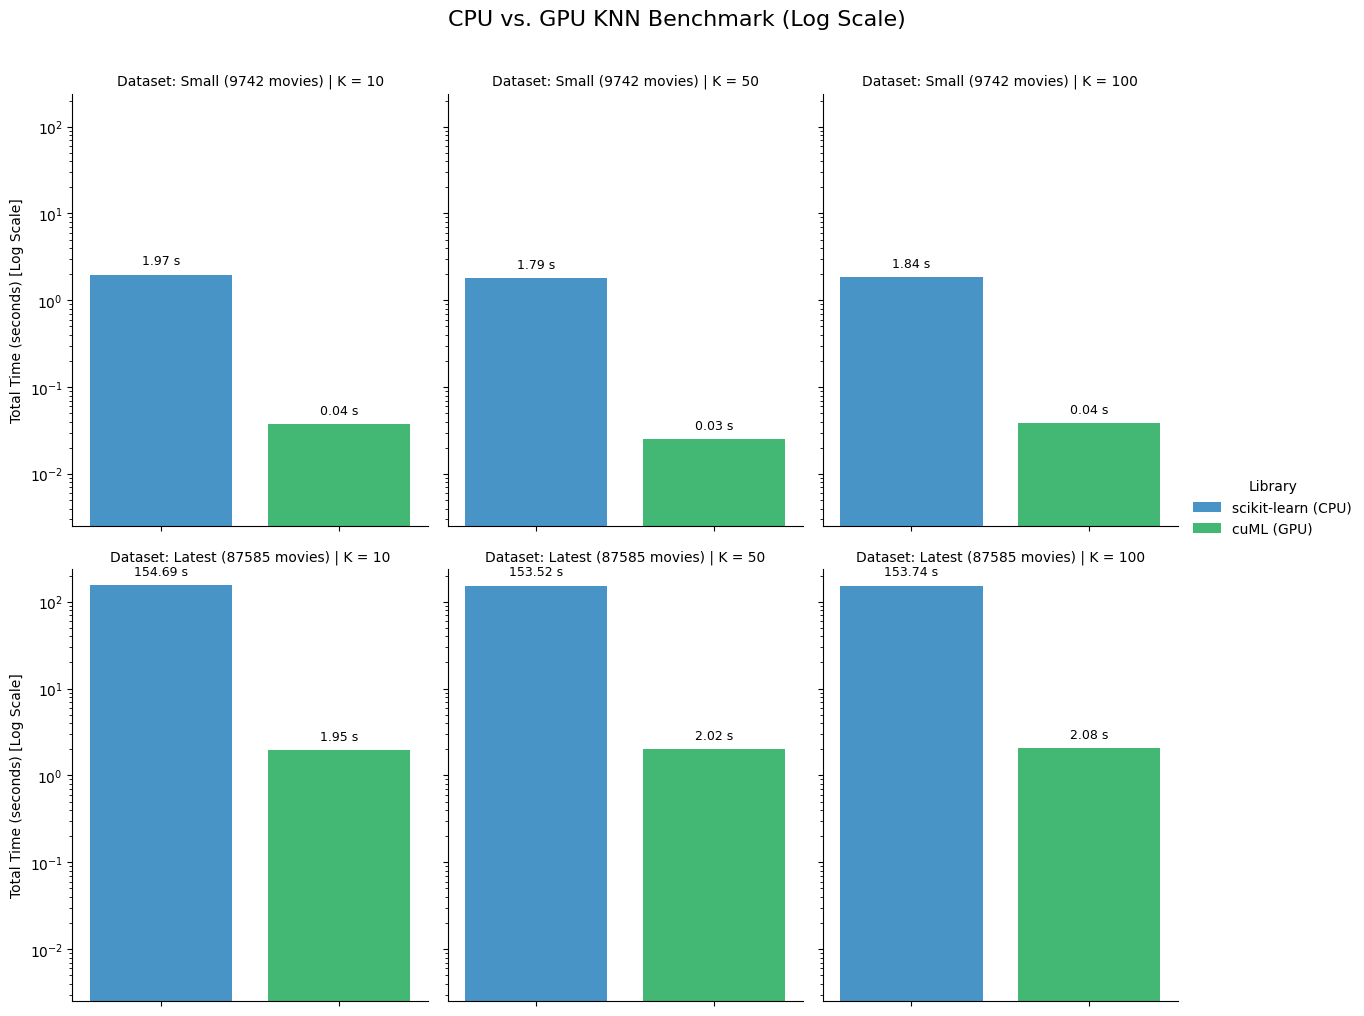

In [41]:
bench_df = pd.DataFrame(benchmark_results)

print("--- Benchmark Results ---")
print("\nFull Data Table:")
print(bench_df.to_markdown(index=False, floatfmt=".4f"))

bench_pivot = bench_df.pivot_table(
    index=['Dataset', 'K'],
    columns='Library',
    values='Time (s)'
)
bench_pivot['Speedup (x)'] = bench_pivot['scikit-learn (CPU)'] / bench_pivot['cuML (GPU)']

print("\nSpeedup Analysis Table:")
print(bench_pivot.to_markdown(floatfmt=".2f"))

print("\nPlotting results as grouped bar charts...")

g = sns.catplot(
    data=bench_df,
    x='Library',
    y='Time (s)',
    hue='Library',
    col='K',
    row='Dataset',
    kind='bar',
    palette=['#3498db', '#2ecc71'],
    legend=True,
    height=5,
    aspect=0.8
)

g.set(yscale='log')

for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.2f} s",
                (p.get_x() + p.get_width() / 2., height),
                ha='center',
                va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=9,
                color='black'
            )

g.fig.suptitle("CPU vs. GPU KNN Benchmark (Log Scale)", y=1.05, fontsize=16)
g.set_axis_labels("", "Total Time (seconds) [Log Scale]")
g.set_titles("Dataset: {row_name} | K = {col_name}")

min_val = bench_df['Time (s)'].min()
g.set(ylim=(min_val * 0.1, None))
g.set_xticklabels([])

plt.show()

## Conclusion (K-Scaling Analysis)

This benchmark tested performance by scaling both the dataset size ($N$) and the number of neighbors ($K$).

The results are clear:

1.  **Massive Parallelism:** The GPU (cuML) remains orders of magnitude faster than the CPU (scikit-learn) in all scenarios. On the large "Latest" dataset, the GPU completed the task in **~2 seconds**, while the CPU required **~155 seconds** (over 2.5 minutes).

2.  **Scalability (vs. N):** The GPU's advantage *dramatically* increases with dataset size ($N$). As seen in the pivot table, the speedup factor jumped from **~49x** on the "Small" dataset to **~81x** on the "Latest" dataset (at K=10).

3.  **Scalability (vs. K):** A key insight from this test is that changing `K` (the number of neighbors) from 10 to 100 had a **negligible impact on performance** for both systems.
    * The CPU's time on the large dataset remained flat at ~155 seconds.
    * The GPU's time increased only slightly (from 1.92s to 2.04s).
    * This proves that for a `brute-force` $O(N^2)$ algorithm, the overwhelming bottleneck is the **distance calculation** (comparing all 7.6 billion pairs), not the **neighbor selection** (sorting to find the top K).

For modern, large-scale data, GPU acceleration is a game-changing technology. It provides superior performance and scalability, reducing tasks that take minutes for a CPU down to mere seconds.